In [1]:
!ls ./results/ -la
!date

total 537564
drwxr-xr-x 3 pabloleo96 pabloleo96      4096 jun 28 08:15 .
drwxr-xr-x 9 pabloleo96 pabloleo96      4096 jun 28 12:32 ..
-rw-r--r-- 1 pabloleo96 pabloleo96  13176264 jun 27 19:54 best_model_mobilenet.h5
-rw-r--r-- 1 pabloleo96 pabloleo96 537266584 jun 28 12:22 best_model_vgg_16.h5
-rw-r--r-- 1 pabloleo96 pabloleo96      1268 jun 28 08:15 best_model_vgg_16.h5_score.txt
drwxr-xr-x 2 pabloleo96 pabloleo96      4096 jun 13 19:36 .ipynb_checkpoints
jue jun 28 12:33:14 CEST 2018


In [2]:
import time
from IPython.display import clear_output
while True:
    !nvidia-smi
    time.sleep(1)
    print(clear_output())

None
Thu Jun 28 12:33:16 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.81                 Driver Version: 384.81                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 750     Off  | 00000000:01:00.0 Off |                  N/A |
| 33%   37C    P8     1W /  38W |     11MiB /  2000MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K40c          Off  | 00000000:02:00.0 Off |                    0 |
| 30%   55C    P8    21W / 235W |     11MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
   

KeyboardInterrupt: 

## Test model

In [7]:
import os, cv2
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# keras imports
import keras
from utils.create_model import create_VGG, create_MobileNet
from utils.data_utils import load_ava, clean_data
from utils.score_utils import mean_score, std_score

# model selection
from sklearn.model_selection import train_test_split

# allow memmory dynamic memmory allocation
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

# random seed to make the kernel reproducible
random_seed = 123456789
np.random.seed(random_seed)

In [8]:
#model_name = 'mobilenet'
model_name = 'vgg_16'

#model = create_MobileNet()
model = create_VGG()
model.load_weights('./results/best_model_{}.h5'.format(model_name))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [9]:
# directory where we are going to work on
workdir = '/home/frubio/AVA/'

# annotations and images directories
train_dir_annotations = os.path.join(workdir, 'AVA_dataset')
train_dir_images = os.path.join(workdir, 'AVA_images')

In [10]:
# load and clean the dataset
x_train, y_train = load_ava(train_dir_annotations)
x_train, y_train = clean_data(train_dir_images, x_train, y_train)

Total images lost:  178
Original dataset shape:  (255530,)
Resulting dataset shape:  (255352,)


In [11]:
# split train and validationy_train
x_train, x_validation, y_train, y_validation = train_test_split(x_train, 
                                                                y_train, 
                                                                test_size = 0.2,
                                                                random_state = random_seed)

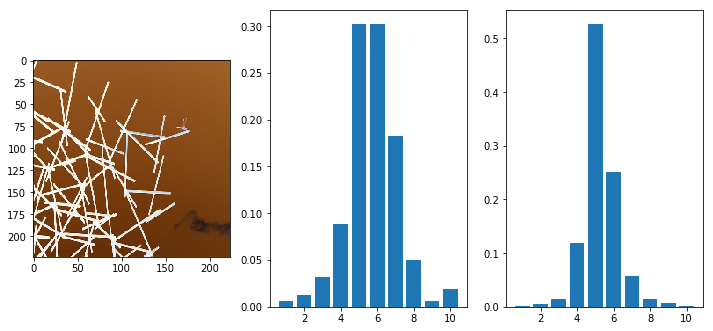

Real Score: 5.723 (±1.4)
Pred Score: 5.278 (±0.979)


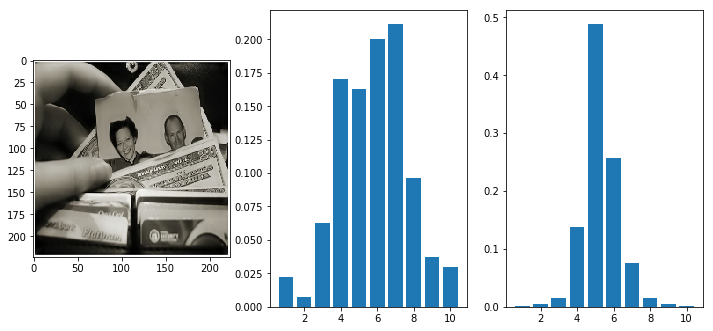

Real Score: 5.8 (±1.857)
Pred Score: 5.29 (±0.997)


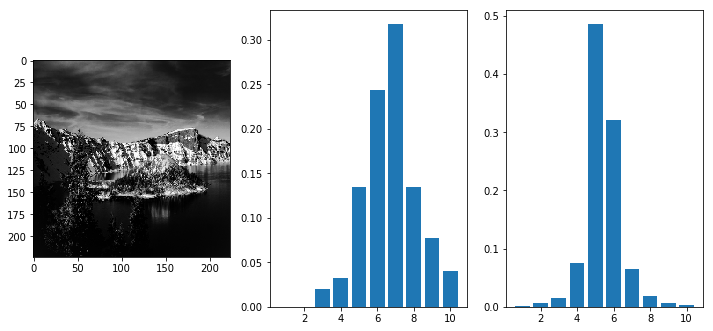

Real Score: 6.72 (±1.459)
Pred Score: 5.414 (±0.992)


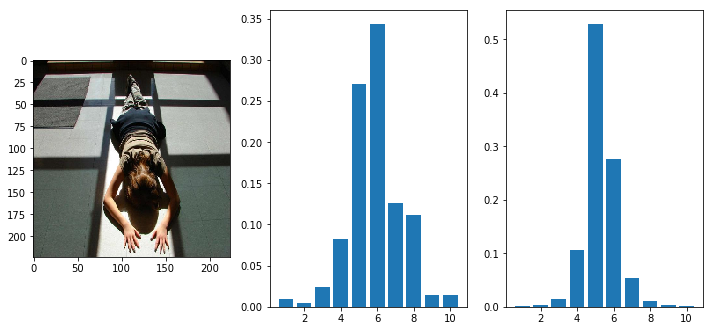

Real Score: 5.874 (±1.432)
Pred Score: 5.287 (±0.913)


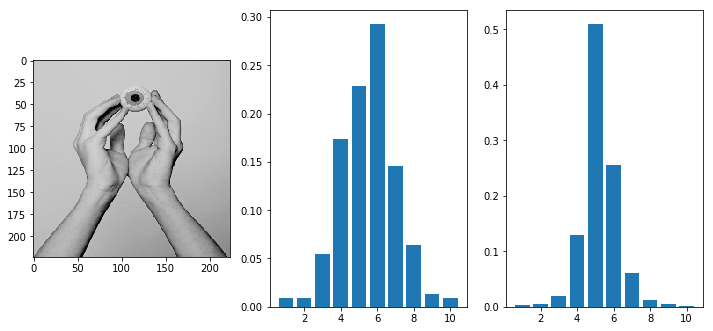

Real Score: 5.53 (±1.497)
Pred Score: 5.25 (±0.981)


In [12]:
# set the number of images to pick
n_images = 5

# pick n_images randomly and load them into memory
image_idxs = np.random.choice(np.arange(len(x_validation)), n_images, replace = False)

images = []
# load the images into memory
for i in range(n_images):
    case = os.path.join(train_dir_images, str(x_validation[image_idxs[i]]) + '.jpg')
    image = cv2.resize(cv2.cvtColor(cv2.imread(case, 1), cv2.COLOR_BGR2RGB), (224, 224))/255
    images.append(image)

# get the predictions
images = np.array(images)
y_pred = model.predict(images).squeeze()
y_true = y_validation[image_idxs]

# plot the results
for i in range(n_images):
    plt.figure(figsize=(12, 12))
    plt.subplot(2, 3, 1)
    plt.imshow(images[i])
    plt.subplot(2, 3, 2)
    y_true_norm = y_true[i] / np.sum(y_true[i])
    plt.bar(np.arange(1,11), height = y_true_norm)
    plt.subplot(2, 3, 3)
    y_pred_norm = y_pred[i]
    plt.bar(np.arange(1,11), height = y_pred_norm)
    plt.show()
    print('Real Score: {} ({}{})'.format(round(mean_score(y_true_norm), 3), chr(177), round(std_score(y_true_norm), 3)))
    print('Pred Score: {} ({}{})'.format(round(mean_score(y_pred_norm), 3), chr(177), round(std_score(y_pred_norm), 3)))